In [7]:
%pip install torchvision

     -------------------------------------- 228.5/228.5 MB 3.6 MB/s eta 0:00:00
     -------------------------------------- 286.9/286.9 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [8]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce GTX 1650


In [6]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [12]:

data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder('D:/Github/food-101.zip/food-101/food-101/food-101/images', transform=data_transforms)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [14]:
import os
import random
import shutil
from tqdm import tqdm

def reduce_dataset(source_dir, target_dir, reduction_factor=0.1):
    """
    Reduce the size of the Food-101 dataset by randomly selecting a subset of images from each class.
    
    :param source_dir: Path to the original Food-101 dataset
    :param target_dir: Path to store the reduced dataset
    :param reduction_factor: Fraction of images to keep (default is 0.1 for 10%)
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Load the dataset using ImageFolder
    dataset = datasets.ImageFolder(source_dir)

    # Get all class names
    class_names = dataset.classes

    for class_idx, class_name in enumerate(tqdm(class_names, desc="Processing classes")):
        source_class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        
        # Create the class directory in the target
        os.makedirs(target_class_dir, exist_ok=True)
        
        # Get all image files for this class
        class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        
        # Calculate how many images to keep
        num_to_keep = int(len(class_indices) * reduction_factor)
        
        # Randomly select images
        selected_indices = random.sample(class_indices, num_to_keep)
        
        # Copy selected images to the target directory
        for idx in selected_indices:
            source_path, _ = dataset.samples[idx]
            image_name = os.path.basename(source_path)
            target_path = os.path.join(target_class_dir, image_name)
            shutil.copy2(source_path, target_path)

    print(f"Dataset reduction complete. Reduced dataset saved to {target_dir}")

# Usage
if __name__ == "__main__":
    source_directory = 'D:/Github/food-101.zip/food-101/food-101/food-101/images'  # Replace with your Food-101 dataset path
    target_directory = 'D:/Github/food-101.zip/food-101/food-101/food-101/reduced_images'   # Replace with where you want to save the reduced dataset
    
    reduce_dataset(source_directory, target_directory)

Processing classes: 100%|██████████| 101/101 [02:13<00:00,  1.32s/it]

Dataset reduction complete. Reduced dataset saved to D:/Github/food-101.zip/food-101/food-101/food-101/reduced_images


In [20]:
len(train_loader)


2525

In [21]:
# Step 3: Model Architecture
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

class FoodClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FoodClassifier, self).__init__()
        self.base_model = mobilenet_v2(pretrained=True)
        
        # Remove the last fully connected layer
        self.base_model.classifier = nn.Identity()
        
        # Add new classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return self.classifier(x)

# Create the model
num_classes = len(dataset.classes)  # Use the number of classes from your dataset
model = FoodClassifier(num_classes)

# Move the model to the device (GPU if available)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\abhag/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:04<00:00, 3.24MB/s]


In [23]:
# Step 4: Training the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save the best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print('Training complete')
    return model

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)



Epoch 1/5
----------


Training: 100%|██████████| 2525/2525 [10:58<00:00,  3.84it/s]


Train Loss: 2.2781 Acc: 0.4154


Validation: 100%|██████████| 632/632 [04:30<00:00,  2.34it/s]


Val Loss: 2.0097 Acc: 0.4808
Epoch 2/5
----------


Training: 100%|██████████| 2525/2525 [13:59<00:00,  3.01it/s]  


Train Loss: 1.9804 Acc: 0.4857


Validation: 100%|██████████| 632/632 [03:47<00:00,  2.78it/s]


Val Loss: 1.8364 Acc: 0.5221
Epoch 3/5
----------


Training: 100%|██████████| 2525/2525 [11:51<00:00,  3.55it/s]


Train Loss: 1.8068 Acc: 0.5256


Validation: 100%|██████████| 632/632 [01:23<00:00,  7.53it/s]


Val Loss: 1.7237 Acc: 0.5475
Epoch 4/5
----------


Training: 100%|██████████| 2525/2525 [11:10<00:00,  3.77it/s]


Train Loss: 1.6697 Acc: 0.5600


Validation: 100%|██████████| 632/632 [01:24<00:00,  7.44it/s]


Val Loss: 1.6179 Acc: 0.5734
Epoch 5/5
----------


Training: 100%|██████████| 2525/2525 [11:09<00:00,  3.77it/s]


Train Loss: 1.5611 Acc: 0.5856


Validation: 100%|██████████| 632/632 [01:24<00:00,  7.51it/s]

Val Loss: 1.5520 Acc: 0.5961
Training complete


In [25]:
# ... existing code ...

import os
import shutil
from tqdm import tqdm

def create_test_dataset(source_dir, target_dir, test_file_path):
    """
    Create a test dataset folder by copying images listed in the test.txt file.
    
    :param source_dir: Path to the original Food-101 dataset
    :param target_dir: Path to store the test dataset
    :param test_file_path: Path to the test.txt file containing image IDs
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Read the test.txt file
    with open(test_file_path, 'r') as f:
        test_images = f.read().splitlines()

    # Copy images to the test folder
    for image_id in tqdm(test_images, desc="Copying test images"):
        # Split the image_id into class name and file name
        class_name, file_name = image_id.split('/')
        
        # Construct the source and target paths
        source_path = os.path.join(source_dir, class_name, f"{file_name}.jpg")
        target_class_dir = os.path.join(target_dir, class_name)
        
        # Create the class directory in the target if it doesn't exist
        os.makedirs(target_class_dir, exist_ok=True)
        
        # Copy the image
        target_path = os.path.join(target_class_dir, f"{file_name}.jpg")
        shutil.copy2(source_path, target_path)

    print(f"Test dataset creation complete. Test images saved to {target_dir}")

# Usage
if __name__ == "__main__":
    source_directory = 'D:/Github/food-101.zip/food-101/food-101/food-101/images'  # Replace with your Food-101 dataset path
    test_directory = 'D:/Github/food-101.zip/food-101/food-101/food-101/test_images'   # Replace with where you want to save the test dataset
    test_file_path = 'D:/Github/food-101.zip/food-101/food-101/food-101/meta/test.txt'  # Replace with the path to your test.txt file
    
    create_test_dataset(source_directory, test_directory, test_file_path)

# ... existing code ...

Copying test images: 100%|██████████| 25250/25250 [00:27<00:00, 920.80it/s] 

Test dataset creation complete. Test images saved to D:/Github/food-101.zip/food-101/food-101/food-101/test_images


In [26]:
# Create a test dataset and loader
test_dataset = datasets.ImageFolder('D:/Github/food-101.zip/food-101/food-101/food-101/test_images', transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [27]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return all_preds, all_labels

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
predictions, true_labels = evaluate_model(model, test_loader, criterion)

Testing: 100%|██████████| 790/790 [02:30<00:00,  5.27it/s]

Test Loss: 1.2170 Acc: 0.6632


                         precision    recall  f1-score   support

              apple_pie       0.43      0.31      0.36       250
         baby_back_ribs       0.69      0.68      0.68       250
                baklava       0.79      0.70      0.74       250
         beef_carpaccio       0.63      0.84      0.72       250
           beef_tartare       0.81      0.65      0.72       250
             beet_salad       0.72      0.46      0.57       250
               beignets       0.76      0.79      0.78       250
               bibimbap       0.82      0.81      0.82       250
          bread_pudding       0.53      0.38      0.44       250
      breakfast_burrito       0.35      0.49      0.41       250
             bruschetta       0.51      0.64      0.57       250
           caesar_salad       0.46      0.89      0.61       250
                cannoli       0.71      0.55      0.62       250
          caprese_salad       0.72      0.65      0.68       250
            carrot_cake 

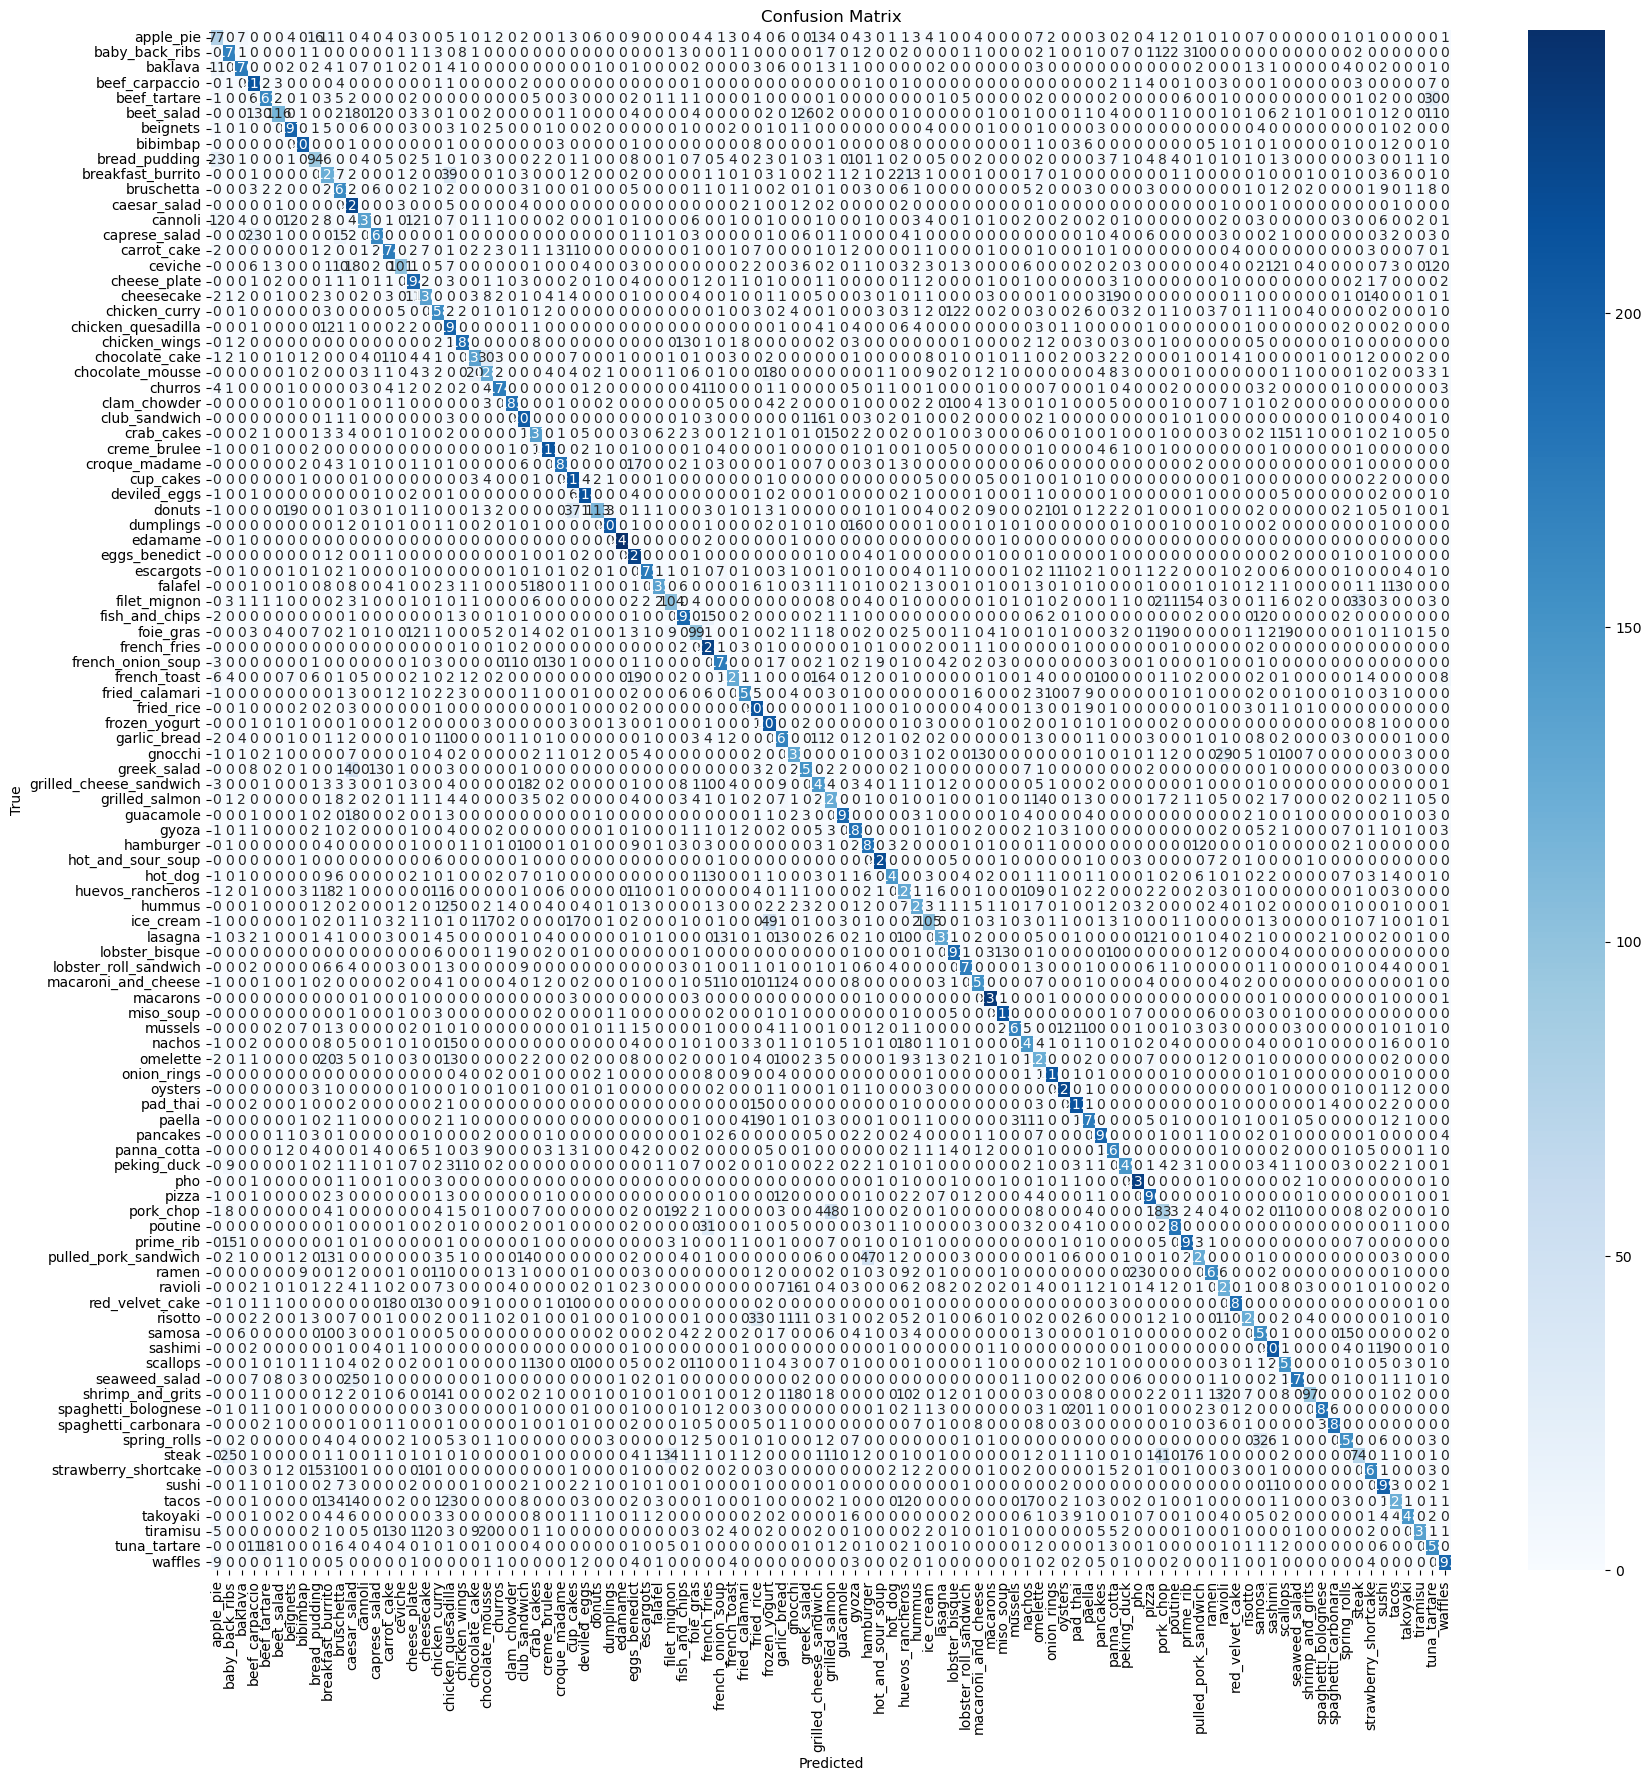

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(true_labels, predictions, target_names=test_dataset.classes))

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()